In [ ]:
%reset -f
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
from torch import device as torch_device

#devices = [torch_device('cuda', i) for i in range(torch.cuda.device_count())] + [torch_device('cpu')]
#print(devices)
desired_gpu_index = 1
device = torch.device(f'cuda:{desired_gpu_index}')
device

In [1]:
import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import random
random.seed(20)
np.random.seed(20)
torch.manual_seed(20)
torch.cuda.manual_seed(20)
device

device(type='cuda')

In [3]:
import cv2
import glob
import random
from tqdm import tqdm
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import nibabel as nib
from scipy import ndimage
from torchmetrics import Dice
import torch.optim as optim


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
import albumentations as A
import time
from tqdm.notebook import tqdm
from torchsummary import summary


In [4]:
def dice_loss(pred, target):
    smooth = 1.#1e-5
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice
def dice_coeff(pred, target):
    smooth = 1.#1e-5
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

import copy
def get_normalized(scann,mn,mx):
    scan = copy.copy(scann)
    mn = max(mn,np.amin(scan))
    mx = min(mx,np.amax(scan))
    np.clip(scan, mn, mx, out=scan)
    d = mx - mn
    scan = (scan-mn)/d
    return scan

def res_scan(nscan,image_size):

    depth_factor = image_size[0]/nscan.shape[0]
    width_factor = image_size[2]/nscan.shape[2]
    height_factor = image_size[1]/nscan.shape[1]
    nscann = copy.copy(nscan)
    nscann = ndimage.zoom(nscann, (depth_factor, height_factor, width_factor), order=1)
    return nscann

def res_mask(nmask,image_size):
    depth_factor = image_size[0]/nmask.shape[0]
    width_factor = image_size[2]/nmask.shape[2]
    height_factor = image_size[1]/nmask.shape[1]

    nmaskk = copy.copy(nmask)
    nmaskk = ndimage.zoom(nmaskk, (depth_factor, height_factor, width_factor), order=1, mode = 'nearest')
    return nmaskk

In [5]:
def random_crop_3d_samples(image_volume, mask_volume, crop_size, num_samples=4, pos=1,neg=1):
    # Convert the image and mask volumes to TensorFlow tensors
#     image_volume = tf.constant(image_volume, dtype=tf.float32)
#     mask_volume = tf.constant(mask_volume, dtype=tf.float32)

    depth, height, width = image_volume.shape

    # Create an empty list to store the cropped samples
    cropped_samples_i = []
    cropped_samples_m = []

    # Calculate the positive and negative sample counts based on the ratio
    num_pos_samples = int(num_samples * (pos/(pos+neg)))
    num_neg_samples = num_samples - num_pos_samples
    p =  np.random.randint(0, 40)
    

    for _ in range(num_pos_samples):
        # Randomly choose a foreground voxel as the center of the crop
        
        pos_indices = np.argwhere(mask_volume > 0)
        rand_index = np.random.randint(low=0, high=pos_indices.shape[0])
        center_coords = pos_indices[rand_index, :]

        # Calculate the starting point of the crop based on the center
        start_depth = max(center_coords[0] - crop_size[0] // 2, 0)
        start_height = max(center_coords[1] - crop_size[1] // 2, 0)
        start_width = max(center_coords[2] - crop_size[2] // 2, 0)

        # Adjust the starting point to avoid out-of-bounds cropping
        start_depth = min(start_depth, depth - crop_size[0])
        start_height = min(start_height, height - crop_size[1])
        start_width = min(start_width, width - crop_size[2])

        # Crop the image and mask volumes
        cropped_image = image_volume[start_depth:start_depth + crop_size[0],
                                     start_height:start_height + crop_size[1],
                                     start_width:start_width + crop_size[2]]

        cropped_mask = mask_volume[start_depth:start_depth + crop_size[0],
                                   start_height:start_height + crop_size[1],
                                   start_width:start_width + crop_size[2]]

        cropped_samples_i.append(cropped_image)
        cropped_samples_m.append(cropped_mask)

    for _ in range(num_neg_samples):
        # Randomly choose a background voxel as the center of the crop
        neg_indices = np.argwhere(mask_volume == 0)
        rand_index = np.random.randint(low=0, high=neg_indices.shape[0])
        center_coords = neg_indices[rand_index, :]

        # Calculate the starting point of the crop based on the center
        start_depth = max(center_coords[0] - crop_size[0] // 2, 0)
        start_height = max(center_coords[1] - crop_size[1] // 2, 0)
        start_width = max(center_coords[2] - crop_size[2] // 2, 0)

        # Adjust the starting point to avoid out-of-bounds cropping
        start_depth = min(start_depth, depth - crop_size[0])
        start_height = min(start_height, height - crop_size[1])
        start_width = min(start_width, width - crop_size[2])

        # Crop the image and mask volumes
        cropped_image = image_volume[start_depth:start_depth + crop_size[0],
                                     start_height:start_height + crop_size[1],
                                     start_width:start_width + crop_size[2]]

        cropped_mask = mask_volume[start_depth:start_depth + crop_size[0],
                                   start_height:start_height + crop_size[1],
                                   start_width:start_width + crop_size[2]]

        cropped_samples_i.append(cropped_image)
        cropped_samples_m.append(cropped_mask)
    random.Random(p).shuffle(cropped_samples_i)
    random.Random(p).shuffle(cropped_samples_m)
    cropped_samples_i = np.array(cropped_samples_i)
    cropped_samples_m = np.array(cropped_samples_m)
    
    return cropped_samples_i, cropped_samples_m



In [6]:
imgpath = sorted(glob.glob(r"/home/rabeea/Task09_Spleen/imagesTr/*.gz", recursive = True))
maskpath = sorted(glob.glob(r"/home/rabeea/Task09_Spleen/labelsTr/*.gz", recursive = True))
tr = 28
val = 5
ts = 8
random.Random(42).shuffle(imgpath)
random.Random(42).shuffle(maskpath)
trainpath = imgpath[:tr]
trainpath_m = maskpath[:tr]
valpath = imgpath[tr:tr+val]
valpath_m = maskpath[tr:tr+val]
testpath = imgpath[tr+val:]
testpath_m = maskpath[tr+val:]
print(len(imgpath), len(trainpath), len(valpath), len(testpath))
print(valpath[:3],valpath_m[:3])

41 28 5 8
['/home/rabeea/Task09_Spleen/imagesTr/spleen_13.nii.gz', '/home/rabeea/Task09_Spleen/imagesTr/spleen_10.nii.gz', '/home/rabeea/Task09_Spleen/imagesTr/spleen_63.nii.gz'] ['/home/rabeea/Task09_Spleen/labelsTr/spleen_13.nii.gz', '/home/rabeea/Task09_Spleen/labelsTr/spleen_10.nii.gz', '/home/rabeea/Task09_Spleen/labelsTr/spleen_63.nii.gz']


In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
# Define custom dataset class


def parse_image(img_path):
    imgg = nib.load(img_path)
    img = imgg.get_fdata()
    #print('image size: ',img.shape)
    x, y, z = imgg.header.get_zooms()
    #print('x, y, z: ',x, y, z)
    new_x = int(x*img.shape[0])
    new_y = int(y*img.shape[1])
    new_z = int(z*img.shape[2])
    image_size = (new_x,new_y,new_z)
    #print('newsize: ',image_size)
    img = res_scan(img, image_size)
    img = get_normalized(img,-57,164)
    
#     mn = np.amin(img)
#     mx = np.amax(img)
#     d = mx - mn
#     img = (img-mn)/d
    #img = np.expand_dims(img, axis=3)
    #train_img = np.stack((image_rgb,)*3, axis=-1)
    
    return img, image_size

def parse_mask(mask_path, image_size):
    mask = nib.load(mask_path)
    mask = mask.get_fdata()
    #mask = np.swapaxes(mask,0,2)
    mask = res_mask(mask, image_size)
    #mask = np.expand_dims(mask, axis=3)
    
    mask = np.where(mask>0,1,mask)
    mask = mask.astype(np.uint8)
    return mask

class DataGen(Dataset):
    def __init__(self, image_size, images_path , mask_path, batch_size=1,num_samples=4, pos_to_neg_ratio=1 ,transform=None):
        self.image_size = image_size
        self.images_path = images_path
        self.mask_path = mask_path
        self.num_samples = num_samples
        self.pos_to_neg_ratio = pos_to_neg_ratio
        self.batch_size = batch_size
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, index):
        image,img_size = parse_image(self.images_path[index])
        mask = parse_mask(self.mask_path[index], img_size)

        image, mask = random_crop_3d_samples(image, mask, self.image_size, self.num_samples, self.pos_to_neg_ratio)
        image = torch.tensor(image)
        mask = torch.from_numpy(mask).long()

        if self.transform is not None:
            image = self.transform(image)

        return image, mask


In [8]:
image_size = (96,96,96)
batch_size = 1
num_samples=4
pos_to_neg_ratio=1
epochs = 400

train_steps = len(trainpath)//batch_size
valid_steps = len(valpath)//batch_size

## Generator
train_gen = DataGen(image_size, trainpath,trainpath_m,batch_size=batch_size,num_samples=4, pos_to_neg_ratio=1)
valid_gen = DataGen(image_size,valpath, valpath_m, batch_size=batch_size,num_samples=4, pos_to_neg_ratio=1 )

train_loader = DataLoader(train_gen, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(valid_gen, batch_size=batch_size,shuffle=False) 

In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print('image type: ',img.dtype)
print('mask type: ', label.dtype)
print('image range: ', torch.max(img), torch.min(img))


Feature batch shape: torch.Size([1, 4, 96, 96, 96])
Labels batch shape: torch.Size([1, 4, 96, 96, 96])
image type:  torch.float64
mask type:  torch.int64
image range:  tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64)


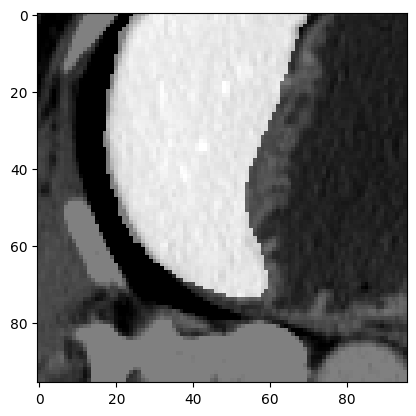

In [10]:
plt.imshow(img[1,:,:,45], cmap="gray")
plt.imshow(label[1,:,:,45], 'gray', alpha=0.5)

In [11]:
heads = 2
dim = 8
embed_dim = 4

In [12]:
from TransBTS_downsample8x_skipconnection import TransBTS
_,model = TransBTS(img_dim = 96, skip = False, sk_e=embed_dim, sk_d=dim, sk_h=heads)
model.to(device)


1728


BTS(
  (linear_encoding): Linear(in_features=128, out_features=512, bias=True)
  (position_encoding): LearnedPositionalEncoding()
  (pe_dropout): Dropout(p=0.1, inplace=False)
  (transformer): TransformerModel(
    (net): IntermediateSequential(
      (0): Residual(
        (fn): PreNormDrop(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (fn): SelfAttention(
            (qkv): Linear(in_features=512, out_features=1536, bias=False)
            (attn_drop): Dropout(p=0.1, inplace=False)
            (proj): Linear(in_features=512, out_features=512, bias=True)
            (proj_drop): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (1): Residual(
        (fn): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=512, out_features=4096, bias=True)
              (1

In [13]:
#optimizer = optim.SGD(model.parameters(), lr=1e-4)#, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, weight_decay=1e-5, amsgrad=True)
torch.cuda.empty_cache()
max_dice = 0
train_losses = []
test_losses = []
train_dices = []
val_dices = []
decrease = 1  
not_improve=0

In [14]:
filename = '/home/rabeea/logs/TransBTS_spleen/model_16_ly4_lr4.pt'
filename_sd = '/home/rabeea/logs/TransBTS_spleen/model_16_ly4_lr4.pth'

In [15]:

fit_time = time.time()
for epoch in range(epochs):
    # Your dataset or data loading logic goes here
    since = time.time()
    # Training
    model.train()
    train_loss = 0
    train_dice = 0
    num_batches = 0
    
    for i,data in enumerate(tqdm(train_loader)):  # Replace train_loader with your data loader
        inputs, labels = data
        # Forward pass
        inputs = inputs.permute(1, 0, 2,3,4)
        labels = labels.permute(1, 0, 2,3,4)
        inputs = inputs.float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # Calculate loss
        loss = dice_loss(outputs, labels)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_dice += dice_coeff(outputs, labels).item()
        num_batches += 1
    
    train_loss /= num_batches
    train_dice /= num_batches
    
    # Validation
    model.eval()
    val_dice = 0.0
    test_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs = val_inputs.permute(1, 0, 2,3,4)
            val_targets = val_targets.permute(1, 0, 2,3,4)
            val_inputs = val_inputs.float()
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(device)
            val_outputs = model(val_inputs)
            val_dice += dice_coeff(val_outputs,val_targets).item()
            test_loss += dice_loss(val_outputs,val_targets).item()
            
    val_dice /= len(val_loader)
    test_loss /= len(val_loader)
    # Perform validation and calculate validation loss and dice coefficient
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_dices.append(train_dice)
    val_dices.append(val_dice)
    if max_dice < val_dice:
        print('Dice increasing.. {:.3f} >> {:.3f} '.format(max_dice, val_dice))
        max_dice = val_dice
        decrease += 1
        not_improve = 0
        #if decrease % 5 == 0:
        print('saving model...')
        #torch.save(model, 'TransAttUNetSkip-{:.3f}.pt'.format(val_dice))
        torch.save(model, filename)
        torch.save(model.state_dict(), filename_sd)
    if max_dice > val_dice:
        not_improve += 1
#         min_loss = test_loss
#         print(f'Loss Not Decrease for {not_improve} time')
        if not_improve == 30:
            print('Loss hasnt decreased for 30 epochs, Stopping Training')
            break
    
    # Print the metrics+
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}, time: {((time.time() - since)/60):.2f}")

    

  0%|          | 0/28 [00:00<?, ?it/s]

Dice increasing.. 0.000 >> 0.212 
saving model...
Epoch 1/400, Train Loss: 0.7600, Train Dice: 0.2400, Val Dice: 0.2122, time: 9.67


  0%|          | 0/28 [00:00<?, ?it/s]

Dice increasing.. 0.212 >> 0.280 
saving model...
Epoch 2/400, Train Loss: 0.7068, Train Dice: 0.2932, Val Dice: 0.2802, time: 9.48


  0%|          | 0/28 [00:00<?, ?it/s]

Dice increasing.. 0.280 >> 0.487 
saving model...
Epoch 3/400, Train Loss: 0.5345, Train Dice: 0.4655, Val Dice: 0.4870, time: 9.45


  0%|          | 0/28 [00:00<?, ?it/s]

Dice increasing.. 0.487 >> 0.658 
saving model...
Epoch 4/400, Train Loss: 0.3248, Train Dice: 0.6752, Val Dice: 0.6578, time: 9.45


  0%|          | 0/28 [00:00<?, ?it/s]

Dice increasing.. 0.658 >> 0.681 
saving model...
Epoch 5/400, Train Loss: 0.2335, Train Dice: 0.7665, Val Dice: 0.6811, time: 9.43


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6/400, Train Loss: 0.2000, Train Dice: 0.8000, Val Dice: 0.4123, time: 9.39


  0%|          | 0/28 [00:00<?, ?it/s]

Dice increasing.. 0.681 >> 0.786 
saving model...
Epoch 7/400, Train Loss: 0.1919, Train Dice: 0.8081, Val Dice: 0.7861, time: 9.40


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8/400, Train Loss: 0.1971, Train Dice: 0.8029, Val Dice: 0.6308, time: 9.42


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9/400, Train Loss: 0.1738, Train Dice: 0.8262, Val Dice: 0.4547, time: 9.44


  0%|          | 0/28 [00:00<?, ?it/s]

Dice increasing.. 0.786 >> 0.837 
saving model...
Epoch 10/400, Train Loss: 0.1607, Train Dice: 0.8393, Val Dice: 0.8369, time: 9.47


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 11/400, Train Loss: 0.1897, Train Dice: 0.8103, Val Dice: 0.7231, time: 9.52


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 12/400, Train Loss: 0.1635, Train Dice: 0.8365, Val Dice: 0.8341, time: 9.54


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 13/400, Train Loss: 0.1506, Train Dice: 0.8494, Val Dice: 0.6197, time: 9.53


  0%|          | 0/28 [00:00<?, ?it/s]

Dice increasing.. 0.837 >> 0.857 
saving model...
Epoch 14/400, Train Loss: 0.1844, Train Dice: 0.8156, Val Dice: 0.8568, time: 9.54


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 15/400, Train Loss: 0.1559, Train Dice: 0.8441, Val Dice: 0.8144, time: 9.53


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 16/400, Train Loss: 0.1375, Train Dice: 0.8625, Val Dice: 0.8094, time: 9.53


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 17/400, Train Loss: 0.1512, Train Dice: 0.8488, Val Dice: 0.8461, time: 9.52


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 18/400, Train Loss: 0.1546, Train Dice: 0.8454, Val Dice: 0.8315, time: 9.46


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 19/400, Train Loss: 0.1260, Train Dice: 0.8740, Val Dice: 0.5695, time: 9.50


  0%|          | 0/28 [00:00<?, ?it/s]

Dice increasing.. 0.857 >> 0.863 
saving model...
Epoch 20/400, Train Loss: 0.1476, Train Dice: 0.8524, Val Dice: 0.8634, time: 9.52


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 21/400, Train Loss: 0.1127, Train Dice: 0.8873, Val Dice: 0.7881, time: 9.56


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 22/400, Train Loss: 0.1295, Train Dice: 0.8705, Val Dice: 0.7814, time: 9.52


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 23/400, Train Loss: 0.1334, Train Dice: 0.8666, Val Dice: 0.7314, time: 9.38


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 24/400, Train Loss: 0.1187, Train Dice: 0.8813, Val Dice: 0.8213, time: 9.36


  0%|          | 0/28 [00:00<?, ?it/s]

Dice increasing.. 0.863 >> 0.879 
saving model...
Epoch 25/400, Train Loss: 0.0906, Train Dice: 0.9094, Val Dice: 0.8790, time: 9.41


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 26/400, Train Loss: 0.1000, Train Dice: 0.9000, Val Dice: 0.7631, time: 9.35


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 27/400, Train Loss: 0.1191, Train Dice: 0.8809, Val Dice: 0.8289, time: 9.34


  0%|          | 0/28 [00:00<?, ?it/s]

Dice increasing.. 0.879 >> 0.882 
saving model...
Epoch 28/400, Train Loss: 0.1216, Train Dice: 0.8784, Val Dice: 0.8824, time: 9.35


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 29/400, Train Loss: 0.1100, Train Dice: 0.8900, Val Dice: 0.8362, time: 9.43


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 30/400, Train Loss: 0.1032, Train Dice: 0.8968, Val Dice: 0.6370, time: 9.36


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 31/400, Train Loss: 0.0946, Train Dice: 0.9054, Val Dice: 0.7986, time: 9.35


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 32/400, Train Loss: 0.1232, Train Dice: 0.8768, Val Dice: 0.8206, time: 9.32


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 33/400, Train Loss: 0.1147, Train Dice: 0.8853, Val Dice: 0.5154, time: 9.43


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 34/400, Train Loss: 0.1007, Train Dice: 0.8993, Val Dice: 0.8394, time: 9.35


  0%|          | 0/28 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 105/400, Train Loss: 0.0523, Train Dice: 0.9477, Val Dice: 0.7721, time: 9.71


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 106/400, Train Loss: 0.0482, Train Dice: 0.9518, Val Dice: 0.7596, time: 9.65


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 107/400, Train Loss: 0.0522, Train Dice: 0.9478, Val Dice: 0.6400, time: 9.66


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 108/400, Train Loss: 0.0489, Train Dice: 0.9511, Val Dice: 0.7634, time: 9.69


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 109/400, Train Loss: 0.0487, Train Dice: 0.9513, Val Dice: 0.8852, time: 9.69


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 110/400, Train Loss: 0.0494, Train Dice: 0.9506, Val Dice: 0.9341, time: 9.68


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 111/400, Train Loss: 0.0471, Train Dice: 0.9529, Val Dice: 0.8981, time: 9.53


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 112/400, Train Loss: 0.0498, Train Dice: 0.9502, Val Dice: 0.9132, time: 9.49


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 113/400, Train Loss: 0.0548, Train Dice: 0.9452, Val Dice: 0.6641, time: 9.46


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 114/400, Train Loss: 0.0471, Train Dice: 0.9529, Val Dice: 0.8889, time: 9.43


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 115/400, Train Loss: 0.0452, Train Dice: 0.9548, Val Dice: 0.9073, time: 9.42


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 116/400, Train Loss: 0.0640, Train Dice: 0.9360, Val Dice: 0.8864, time: 9.40


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 117/400, Train Loss: 0.0788, Train Dice: 0.9212, Val Dice: 0.7492, time: 9.45


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 118/400, Train Loss: 0.1246, Train Dice: 0.8754, Val Dice: 0.7482, time: 9.44


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 119/400, Train Loss: 0.0747, Train Dice: 0.9253, Val Dice: 0.8686, time: 9.43


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 120/400, Train Loss: 0.0673, Train Dice: 0.9327, Val Dice: 0.8882, time: 9.42


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 121/400, Train Loss: 0.0579, Train Dice: 0.9421, Val Dice: 0.9364, time: 9.42


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 122/400, Train Loss: 0.0585, Train Dice: 0.9415, Val Dice: 0.9366, time: 9.38


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 123/400, Train Loss: 0.0708, Train Dice: 0.9292, Val Dice: 0.8700, time: 9.44


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 124/400, Train Loss: 0.0745, Train Dice: 0.9255, Val Dice: 0.8474, time: 9.44


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 125/400, Train Loss: 0.0729, Train Dice: 0.9271, Val Dice: 0.6848, time: 9.40


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 126/400, Train Loss: 0.0740, Train Dice: 0.9260, Val Dice: 0.9341, time: 9.36


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 127/400, Train Loss: 0.0710, Train Dice: 0.9290, Val Dice: 0.8124, time: 9.36


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 128/400, Train Loss: 0.0527, Train Dice: 0.9473, Val Dice: 0.9272, time: 9.40


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 129/400, Train Loss: 0.0614, Train Dice: 0.9386, Val Dice: 0.4612, time: 9.39


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 130/400, Train Loss: 0.0602, Train Dice: 0.9398, Val Dice: 0.9304, time: 9.40


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 131/400, Train Loss: 0.0629, Train Dice: 0.9371, Val Dice: 0.7588, time: 9.42


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 132/400, Train Loss: 0.0611, Train Dice: 0.9389, Val Dice: 0.8882, time: 9.40


  0%|          | 0/28 [00:00<?, ?it/s]

Loss hasnt decreased for 30 epochs, Stopping Training


In [16]:
torch.save(model, filename[:-3] + '_lastepoch.pt')
torch.save(model.state_dict(), filename_sd[:-4] + '_lastepoch.pth')

In [17]:
model.load_state_dict(torch.load(filename_sd))

<All keys matched successfully>

In [18]:
history = {'train_loss' : train_losses, 'val_loss': test_losses,
           'train_dice' :train_dices, 'val_dice':val_dices}

In [19]:
print('max training dice: ',max(train_dices))
print('max validation dice: ',max(val_dices))

max training dice:  0.9548214759145465
max validation dice:  0.9437796354293824


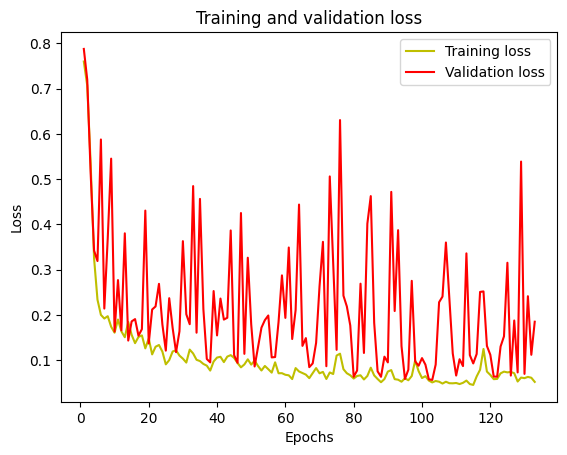

In [20]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

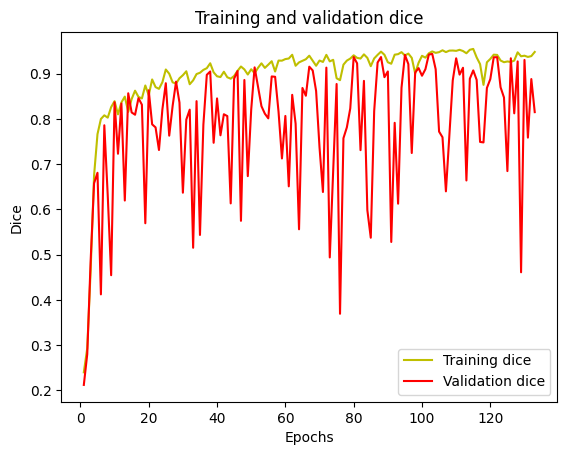

In [21]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_dice']
val_loss = history['val_dice']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice')
plt.plot(epochs, val_loss, 'r', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [39]:
def inf(path,path_m,a):
    a.eval()
    test_volume,img_size = parse_image(path)
    test_mask = parse_mask(path_m, img_size)
    test_mask = np.expand_dims(test_mask, axis=0)
    test_mask = np.expand_dims(test_mask, axis=0)
    test_mask = np.where(test_mask>0,1,test_mask)
    test_mask = test_mask.astype(np.uint8)
    test_maskk = torch.from_numpy(test_mask).long()
    print('mask shape: ', test_maskk.shape)
    depth, height, width = test_volume.shape
    crop_size = (96,96,96)
    # Calculate the number of crops along each axis
    num_crops_depth = (depth) // crop_size[0]
    num_crops_height = (height) // crop_size[1]
    num_crops_width = (width) // crop_size[2]

    # Calculate the amount of padding needed for each dimension
    pad_depth = crop_size[0] - (depth -  num_crops_depth * crop_size[0])
    pad_height = crop_size[1] - (height -  num_crops_height * crop_size[1])
    pad_width = crop_size[2] - (width - num_crops_width * crop_size[2] )
    #print(pad_depth,pad_height,pad_width)
    num_crops_depth = num_crops_depth + 1 if pad_depth > 0 else num_crops_depth
    num_crops_height = num_crops_height + 1 if pad_height > 0 else num_crops_height
    num_crops_width = num_crops_width + 1 if pad_width > 0 else num_crops_width
    #print(num_crops_depth,num_crops_height,num_crops_width)
    # Pad the test volume and test mask to match the crop size
    padded_volume = np.pad(test_volume, ((0, pad_depth), (0, pad_height), (0, pad_width)), mode='constant')
    padded_volume = np.expand_dims(padded_volume, axis=0)
    padded_volume = np.expand_dims(padded_volume, axis=0)
    padded_mask = np.pad(test_mask, ((0,0),(0,0),(0, pad_depth), (0, pad_height), (0, pad_width)), mode='constant')

    pred_mask = np.zeros(test_mask.shape,dtype = 'float32')
    pred_mask = np.pad(pred_mask, ((0,0),(0,0),(0, pad_depth), (0, pad_height), (0, pad_width)), mode='constant')
    pred_mask = torch.tensor(pred_mask)
    pred_mask = pred_mask.to(device)
    print(pred_mask.dtype)
    with torch.no_grad():
        for d in range(num_crops_depth):
            for h in range(num_crops_height):
                for w in range(num_crops_width):
                    # Calculate the starting and ending indices for cropping
                    start_depth = d * crop_size[0]
                    end_depth = (d + 1) * crop_size[0]
                    start_height = h * crop_size[1]
                    end_height = (h + 1) * crop_size[1]
                    start_width = w * crop_size[2]
                    end_width = (w + 1) * crop_size[2]

                    # Crop the sub-volumes for the volume and mask
                    image = padded_volume[:,:,start_depth:end_depth, start_height:end_height, start_width:end_width]
                    image = torch.tensor(image)
                    image = image.float()
                    image = image.to(device)
                    mask = a(image)
                    pred_mask[:,:,start_depth:end_depth, start_height:end_height, start_width:end_width] = mask
    
    pred_mask = pred_mask[:,:,:-pad_depth,:-pad_height,:-pad_width]
    print('pred mask: ',pred_mask.shape)
    return test_maskk.to(device), pred_mask

In [40]:
num_batches = 1
# Validation
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
test_dice005 = []
test_dice001 = []
test_dice0005 = []
test_dice0001 = []
test_dice00005 = []
test_dice00001 = []
test_dice000005 = []
test_dice000001 = []
test_dice0000005 = []
test_dice0000001 = []
for i in tqdm(range(0,len(testpath))):
    val_targets, val_outputs = inf(testpath[i],testpath_m[i],model)
    #print(val_outputs.shape)
    test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
    #print(test_outputs.shape)
    test_dice9.append(dice_coeff(test_outputs,val_targets).item())
    
    test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
    test_dice8.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
    test_dice7.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
    test_dice6.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
    test_dice5.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
    test_dice4.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
    test_dice3.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
    test_dice2.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
    test_dice1.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
    test_dice05.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
    test_dice01.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.005,torch.tensor(1),torch.tensor(0))
    test_dice005.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.001,torch.tensor(1),torch.tensor(0))
    test_dice001.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.0005,torch.tensor(1),torch.tensor(0))
    test_dice0005.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.0001,torch.tensor(1),torch.tensor(0))
    test_dice0001.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.00005,torch.tensor(1),torch.tensor(0))
    test_dice00005.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.00001,torch.tensor(1),torch.tensor(0))
    test_dice00001.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.000005,torch.tensor(1),torch.tensor(0))
    test_dice000005.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.000001,torch.tensor(1),torch.tensor(0))
    test_dice000001.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.0000005,torch.tensor(1),torch.tensor(0))
    test_dice0000005.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.0000001,torch.tensor(1),torch.tensor(0))
    test_dice0000001.append(dice_coeff(test_outputs,val_targets).item())


        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))
print('Test dice at 0.005: ',np.mean(test_dice005))
print('Test dice at 0.001: ',np.mean(test_dice001))
print('Test dice at 0.0005: ',np.mean(test_dice0005))
print('Test dice at 0.0001: ',np.mean(test_dice0001))
print('Test dice at 0.00005: ',np.mean(test_dice00005))
print('Test dice at 0.00001: ',np.mean(test_dice00001))
print('Test dice at 0.000005: ',np.mean(test_dice000005))
print('Test dice at 0.000001: ',np.mean(test_dice000001))
print('Test dice at 0.0000005: ',np.mean(test_dice0000005))
print('Test dice at 0.0000001: ',np.mean(test_dice0000001))

  0%|          | 0/8 [00:00<?, ?it/s]

mask shape:  torch.Size([1, 1, 495, 495, 246])
torch.float32
pred mask:  torch.Size([1, 1, 495, 495, 246])
mask shape:  torch.Size([1, 1, 407, 407, 450])
torch.float32
pred mask:  torch.Size([1, 1, 407, 407, 450])
mask shape:  torch.Size([1, 1, 350, 350, 325])
torch.float32
pred mask:  torch.Size([1, 1, 350, 350, 325])
mask shape:  torch.Size([1, 1, 393, 393, 476])
torch.float32
pred mask:  torch.Size([1, 1, 393, 393, 476])
mask shape:  torch.Size([1, 1, 440, 440, 515])
torch.float32
pred mask:  torch.Size([1, 1, 440, 440, 515])
mask shape:  torch.Size([1, 1, 385, 385, 252])
torch.float32
pred mask:  torch.Size([1, 1, 385, 385, 252])
mask shape:  torch.Size([1, 1, 408, 408, 255])
torch.float32
pred mask:  torch.Size([1, 1, 408, 408, 255])
mask shape:  torch.Size([1, 1, 381, 381, 205])
torch.float32
pred mask:  torch.Size([1, 1, 381, 381, 205])
Test dice at 0.9:  0.7103382684290409
Test dice at 0.8:  0.7102764397859573
Test dice at 0.7:  0.7099776305258274
Test dice at 0.6:  0.709681045

In [42]:
torch.max(val_outputs)

tensor(1., device='cuda:0')